# Mean Square End-to-End Fluctuations

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from os import listdir
import pandas as pd
import statsmodels.api as sm

In [2]:
def CreateLpDataFrame(dirName):
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-6:] == '.mse2e']
    df = pd.DataFrame(columns=['n_filaments','length','persistence_length','driving','ndim','theory','mse2e','std_err'])
    for filename in fileNames:
        f=open(filename)
        f.readline()
        f.readline()
        line = map(float,f.readline().split())
        length,diameter,perlen,driving,ndim,theory = line[0],line[1],line[3],line[4],line[5],line[9]
        f.readline()
        line = f.readline().split()
        num,mse2e,stderr = int(line[0]),float(line[1]),float(line[2])
        f.close()
        temp_df = pd.DataFrame(data={'n_filaments':num,'length':length,'diameter':diameter,'persistence_length':perlen,'driving':driving,'ndim':ndim,'theory':theory,'mse2e':mse2e,'std_err':stderr},index=[1])
        df = df.append(temp_df,ignore_index=True)
    return df

def GetRealUnits(df):
    length_units = lambda x: x*25.0
    inv_length_units = lambda x: x/25.0
    driving_units = lambda dr: dr*0.0064
    force_units = lambda f: f*0.16
    df.loc[:,'length (nm)'] = df['length'].apply(length_units)
    df.loc[:,'diameter (nm)'] = df['diameter'].apply(length_units)
    df.loc[:,'driving (pN/nm)'] = df['driving'].apply(driving_units)
    df.loc[:,'persistence_length (nm)'] = df['persistence_length'].apply(length_units)
    df.loc[:,'mse2e (nm^2)'] = df['mse2e'].apply(length_units)
    df.loc[:,'std_err (nm^2)'] = df['std_err'].apply(length_units)
    df.loc[:,'weights (nm^4)'] = df['std_err'].apply(inv_length_units)
    df.loc[:,'theory (nm^2)'] = df['theory'].apply(length_units)
    df.loc[:,'effective_lp (nm)'] = df['effective_lp'].apply(length_units)
    df.loc[:,'eff_lp_lower (nm)'] = df['eff_lp_lower'].apply(length_units)
    df.loc[:,'eff_lp_upper (nm)'] = df['eff_lp_upper'].apply(length_units)

def BackCalc(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcUpper(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']+row['std_err']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcUpper2(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']+100*row['std_err']*row['std_err']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcLower(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']-row['std_err']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcLower2(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']-100*row['std_err']*row['std_err']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])
    
def BackCalculateLp(df,range_min=50,range_max=50000):
    df.loc[:,'effective_lp'] = df.apply(BackCalc, axis=1)
    df.loc[:,'eff_lp_lower'] = df.effective_lp - df.apply(BackCalcLower, axis=1)
    df.loc[:,'eff_lp_upper'] = df.apply(BackCalcUpper, axis=1) - df.effective_lp
    temp1 = df.apply(BackCalcUpper2, axis=1) - df.effective_lp
    temp2 = df.effective_lp - df.apply(BackCalcLower2, axis=1)
    df.loc[:,"lp_weights"] = 1.0/temp1


### Next cell is raw text, convert back to code to rerun

In [3]:
df = CreateLpDataFrame('mse2e_analysis/')
BackCalculateLp(df)
GetRealUnits(df)
df.to_pickle('mse2e_data.pkl')

In [4]:
df = pd.read_pickle('mse2e_data.pkl')

<IPython.core.display.Javascript object>


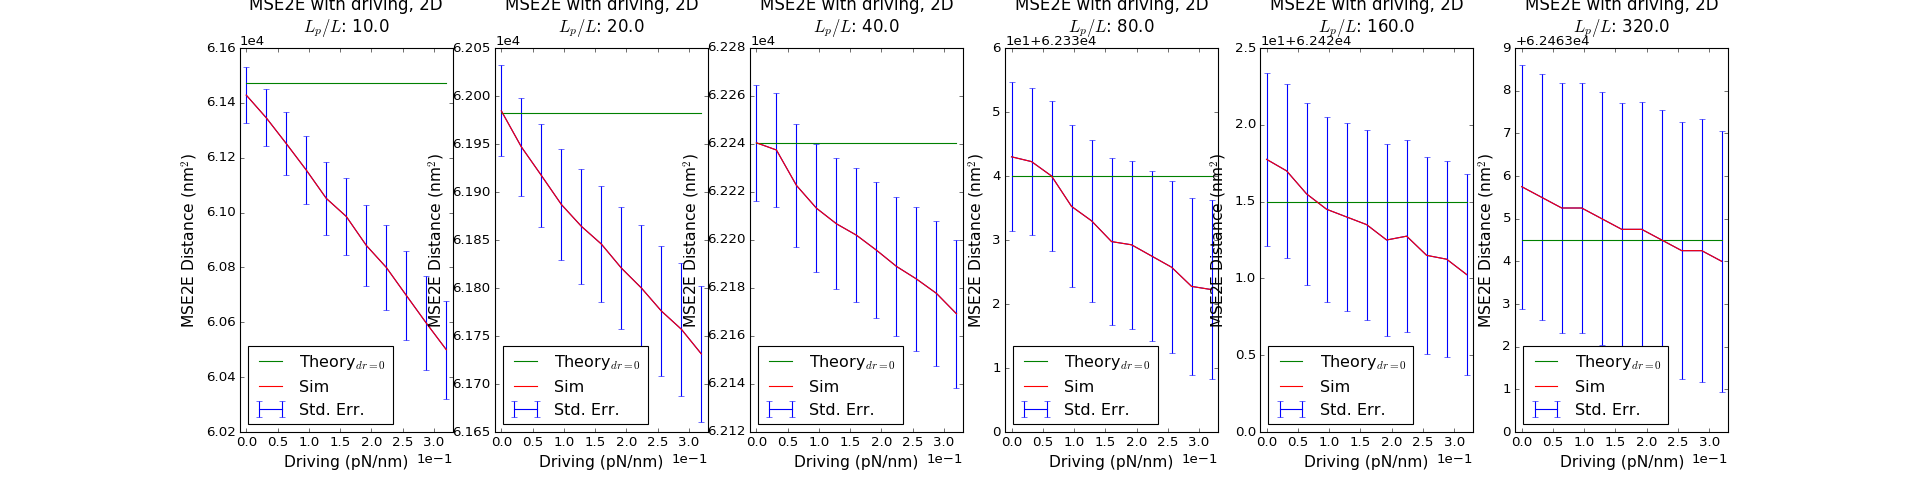

6


In [5]:
df2d = df[df['ndim']==2]
df3d = df[df['ndim']==3]
grouped=df2d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(24,6),dpi=80)
i=0
print len(grouped)
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 2D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend([r'Theory$_{dr=0}$','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
#fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

<IPython.core.display.Javascript object>


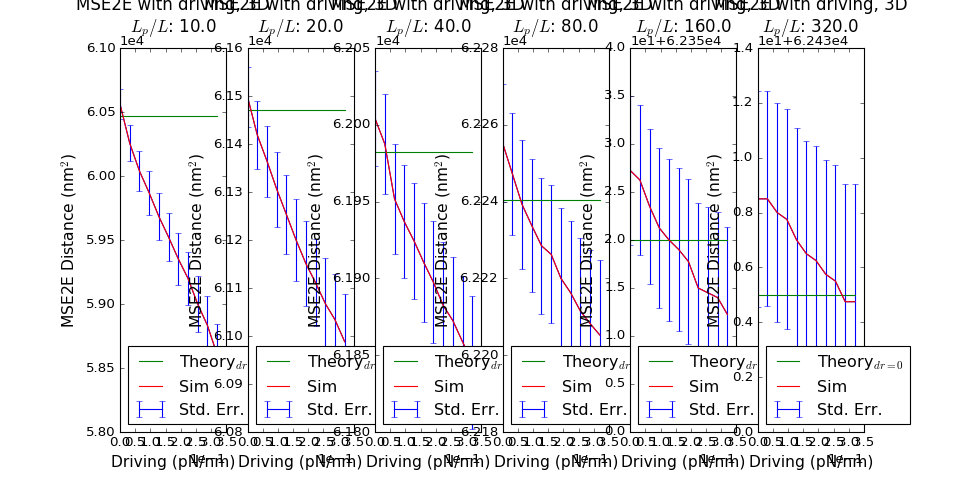

In [6]:
grouped=df3d.groupby('persistence_length (nm)')
fig,axs=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
for ax,(perlen,group) in zip(axs.reshape(-1),grouped):
    ax.set_title("MSE2E with driving, 3D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax.errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax.plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax.plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax.ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax.ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax.set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax.set_xlabel("Driving (pN/nm)",fontsize=14)
    ax.legend([r'Theory$_{dr=0}$','Sim','Std. Err.'],loc=3)
    #ax.set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
#fig.tight_layout()#(rect=(0.05,0.1,0.95,0.9),pad=-1.5)
plt.show()

In [7]:
grouped

<IPython.core.display.Javascript object>


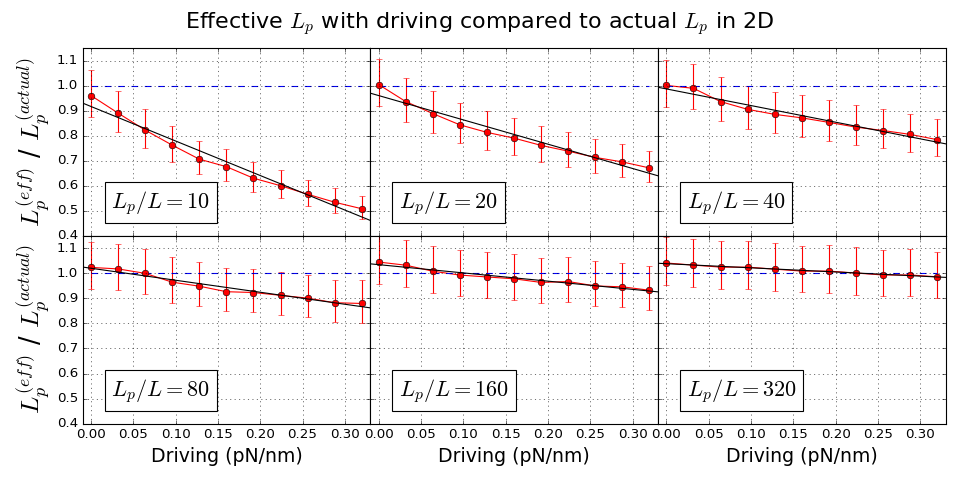

In [8]:
grouped=df2d.groupby('persistence_length (nm)')
fig,axs=plt.subplots(nrows=2,ncols=len(grouped)/2,figsize=(12,6),dpi=80,sharex=True,sharey=True)
#axs[0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
fig.suptitle("Effective " + r'$L_p$' +" with driving compared to actual " r'$L_p$' +" in 2D",fontsize=20)    
axs[0,0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
axs[1,0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
axs[1,0].set_xlabel("Driving (pN/nm)",fontsize=17)
axs[1,1].set_xlabel("Driving (pN/nm)",fontsize=17)
axs[1,2].set_xlabel("Driving (pN/nm)",fontsize=17)

L=[]
lps=[]
for ax,(perlen,group) in zip(axs.reshape(-1),grouped):
    #ax[i].set_title("\n\n"+r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.0)

    ax.errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=(group['eff_lp_lower (nm)']/group['persistence_length (nm)'],group['eff_lp_upper (nm)']/group['persistence_length (nm)']),color='red')
    ax.plot(group['driving (pN/nm)'],group['persistence_length (nm)']/group['persistence_length (nm)'],'b--')
    ax.plot(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],'ro')
    #ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    #ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    #ax[i].set_ylabel(r'Effective $L_p$ / Actual $L_p$',fontsize=14)
    #ax.set_xlabel("Driving (pN/nm)",fontsize=17)
    #ax[i].legend([r'Actual $L_{p}$','Sim w/ driving'],loc=3)
    ax.set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    ax.grid(True)
    ax.set_ylim(0.4,1.15)
    textstr = '$L_p/L=%.0f$'%(perlen/(50*25))
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax.text(0.1, 0.25, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)
    y = group['effective_lp (nm)']/group['persistence_length (nm)']
    X = group['driving (pN/nm)']
    X = sm.add_constant(X)
    mod_wls = sm.OLS(y,X,weights=group['weights (nm^4)'])
    res_wls = mod_wls.fit()
    f = res_wls.params
    xx = np.linspace(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01,100)
    xx=sm.add_constant(xx)
    yy = res_wls.predict(xx)
    ax.plot(xx,yy,'k-')
    L.append([f[1],res_wls.bse[1]])
    lps.append(perlen/(50*25))
L=np.array(L)
#axs[1,2].legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=18,loc=4)
#fig.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=20)

fig.tight_layout(rect=(0,0,1,0.93))
fig.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout(rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

<IPython.core.display.Javascript object>


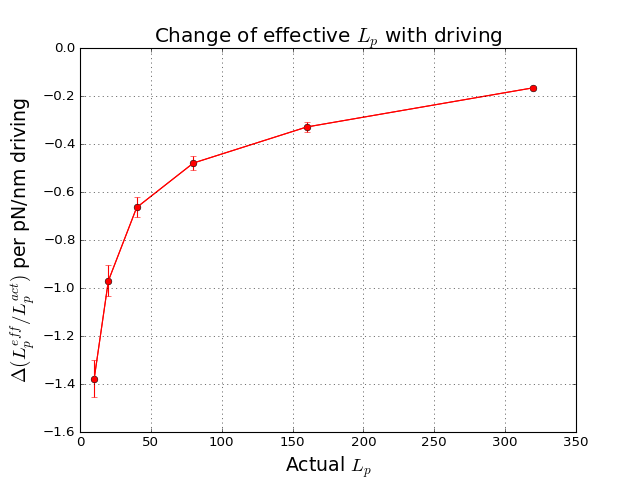

In [9]:
plt.figure()
plt.plot(lps,L[:,0],'ro-')
plt.errorbar(lps,L[:,0],yerr=L[:,1],color='red')
plt.title("Change of effective "+r'$L_p$'+" with driving",fontsize=18)
plt.ylabel(r'$\Delta (L_p^{eff}/L_p^{act})$ per pN/nm driving',fontsize=17)
plt.xlabel(r'Actual $L_p$',fontsize=17)
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


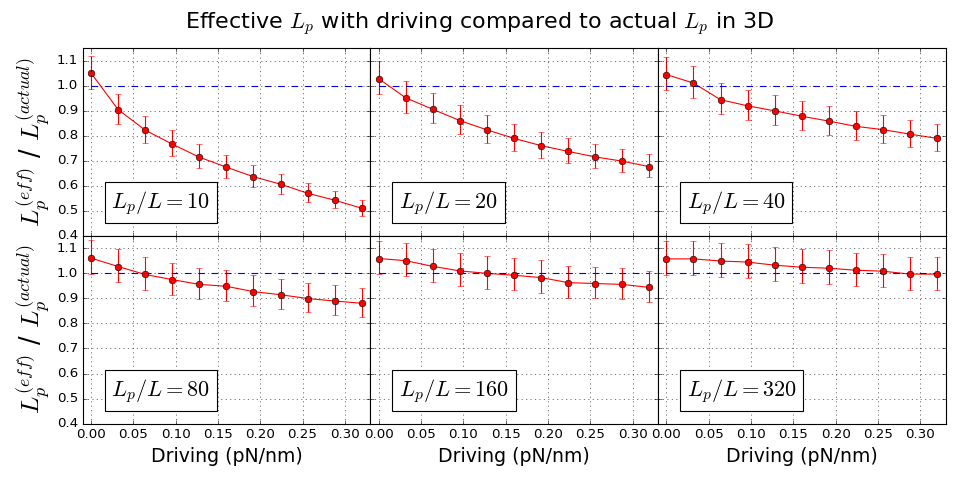

In [10]:
grouped=df3d.groupby('persistence_length (nm)')
fig,axs=plt.subplots(nrows=2,ncols=len(grouped)/2,figsize=(12,6),dpi=80,sharex=True,sharey=True)
#axs[0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
fig.suptitle("Effective " + r'$L_p$' +" with driving compared to actual " r'$L_p$' +" in 3D",fontsize=20)    
axs[0,0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
axs[1,0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
axs[1,0].set_xlabel("Driving (pN/nm)",fontsize=17)
axs[1,1].set_xlabel("Driving (pN/nm)",fontsize=17)
axs[1,2].set_xlabel("Driving (pN/nm)",fontsize=17)

for ax,(perlen,group) in zip(axs.reshape(-1),grouped):
    #ax[i].set_title("\n\n"+r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.0)

    ax.errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=(group['eff_lp_lower (nm)']/group['persistence_length (nm)'],group['eff_lp_upper (nm)']/group['persistence_length (nm)']),color='red')
    ax.plot(group['driving (pN/nm)'],group['persistence_length (nm)']/group['persistence_length (nm)'],'b--')
    ax.plot(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],'ro')
    #ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    #ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    #ax[i].set_ylabel(r'Effective $L_p$ / Actual $L_p$',fontsize=14)
    #ax.set_xlabel("Driving (pN/nm)",fontsize=17)
#    ax[i].legend([r'Actual $L_{p}$','Sim w/ driving'],loc=3)
    ax.set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    ax.grid(True)
    ax.set_ylim(0.4,1.15)
    textstr = '$L_p/L=%.0f$'%(perlen/(50*25))
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax.text(0.1, 0.25, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

#axs[2].legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=18,loc=4)
#fig.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=20)

fig.tight_layout(rect=(0,0,1,0.93))
fig.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout(rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

In [11]:
mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
mse2e_func(50,5000,3)

2491.6874584053294